
# Using Folium's HeatMapWithTime to Unearth Geo-Data Insights: An Applied Walkthrough 🦅
 _By Cian Prendergast_ 

### **Introduction:**
There's a haunting beauty in the songs of the birds of Ireland. However, recent studies point towards a rather bleak reality. A whopping 54 species of birds, which equates to over 26% of the studied population, now find themselves on the endangered Red list. This is a clarion call for action.

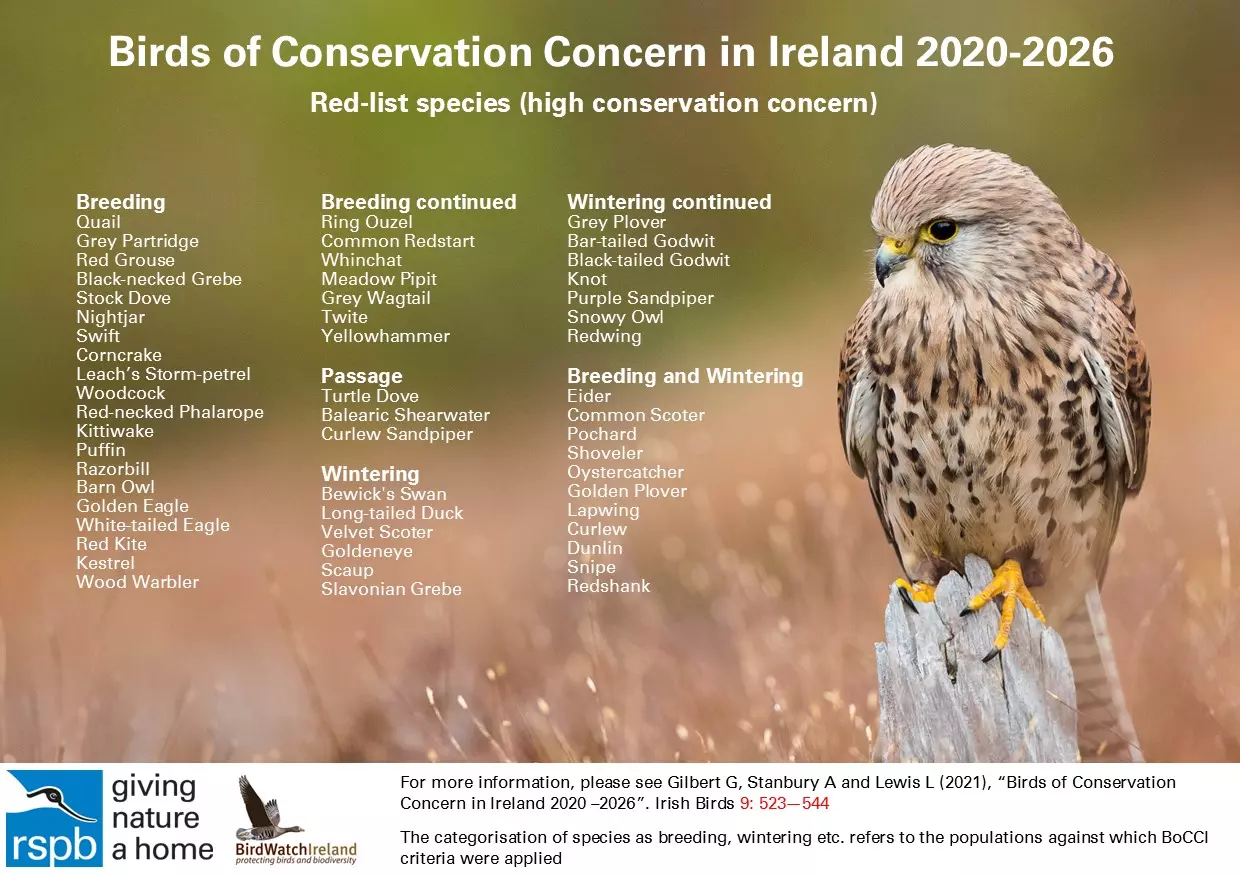

To better understand and advocate for these birds, we delve into a dataset provided by [Biodiversity Ireland](https://maps.biodiversityireland.ie/Dataset/155). In this article, we will process and analyze this dataset, presenting our findings to highlight the importance of conserving these species.

### **Data Retrieval and Preparation:**
Our dataset, initially a `.txt` file, was converted into a more manageable `.csv` format. Before diving into the data, let's load our essential libraries:

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
```

While briefly reviewing the dataset, I observed that many longitude/latitude values were missing. These were predominantly from older entries (1990's) that utilized the Irish OSI Map references. While converting these was beyond the scope of my available time, you can learn more at th [OSI Co-ordinate Converter](https://gnss.osi.ie/new-converter/). Once the older OSI references were removed we were left with 48,172 rows!

The dataset was read into a DataFrame. Pay attention to the delimiter used to split the data, given the tab-separated nature of our dataset:

```python
df = pd.read_csv(r"C:\Users\Cian\Workstation\Datasets\Bird_dataset.txt", "\t+|\t+", encoding='UTF-8', engine='python')
```

We can have a quick look at the dataset using `df.head()`

```
RecordKey	StartDate	EndDate	DateType	Date	TaxonVersionKey	TaxonName	Longitude	Latitude	Grid Reference	...	Habitat description	Abundance	Determiner name	Survey name	Common name	Site description	Source	Habitat code (Fossitt, 2000)	Type of sighting	Activity
0	9.97173E+16	28/02/2022	28/02/2022	D	28/02/2022	NHMSYS0000530420	Lagopus lagopus	-9.859652	53.883251	WGS84	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
1	9.97173E+16	21/02/2022	21/02/2022	D	21/02/2022	NHMSYS0000530420	Lagopus lagopus	-6.299050	53.037785	WGS84	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
2	9.97173E+16	16/02/2022	16/02/2022	D	16/02/2022	NHMSYS0000530420	Lagopus lagopus	-6.221776	53.156033	WGS84	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
3	9.97173E+16	04/02/2022	04/02/2022	D	04/02/2022	NHMSYS0000530420	Lagopus lagopus	-6.461017	52.940109	WGS84	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
4	9.97173E+16	04/02/2022	04/02/2022	D	04/02/2022	NHMSYS0000530420	Lagopus lagopus	-6.460975	52.940112	WGS84	...	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN	NaN
```


### **Data Cleaning:**
The initial exploration showed some rows with missing longitude and latitude data, which were removed for the sake of accurate geospatial analysis:

```python
df.dropna(subset = ['Longitude', 'Latitude'], inplace=True)
```

To ensure that our data truly represents bird sightings in Ireland, we plotted our latitude and longitude data. Our aim was to identify outliers that fall outside the geographical boundaries of Ireland:

```python
# reference: https://github.com/Shreyas3108/house-price-prediction/blob/master/housesales.ipynb
plt.figure(figsize=(10,10))
sns.jointplot(x=df.Latitude.values, y=df.Longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()
sns.despine
```

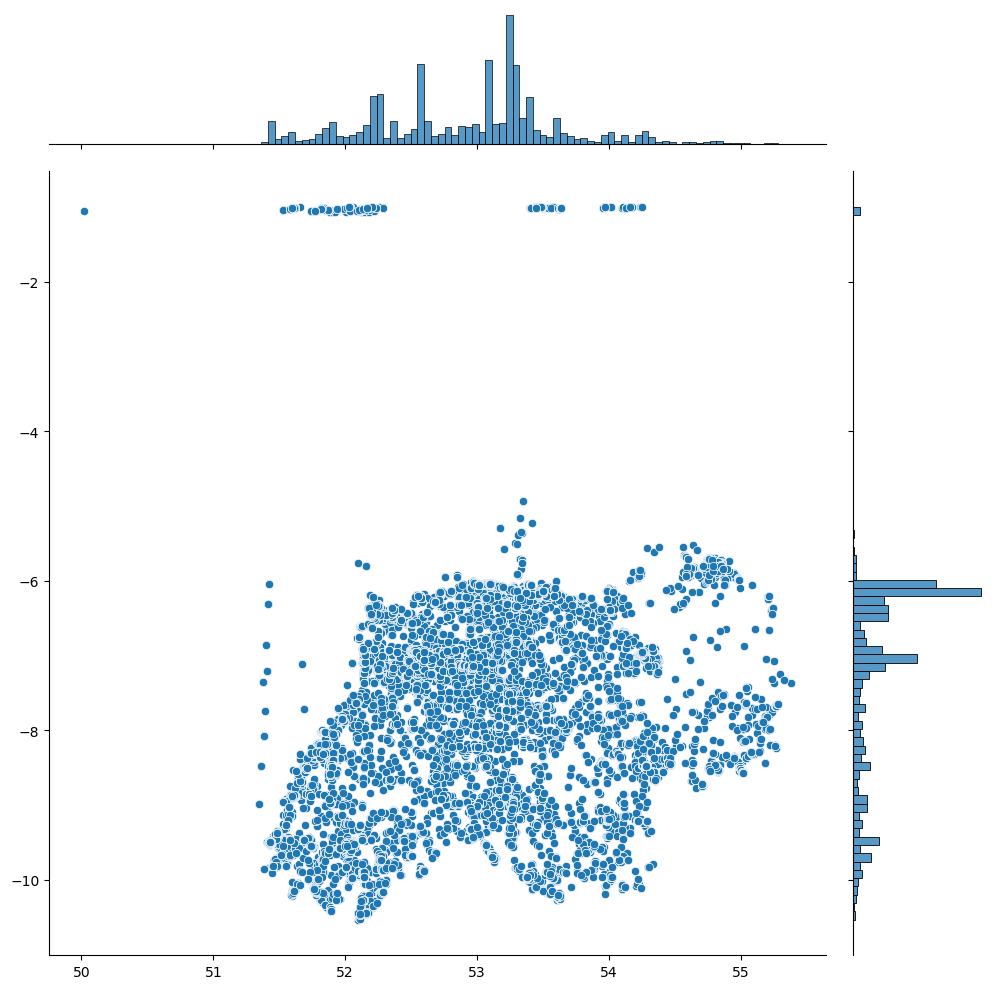

From this visual, outliers were particularly evident along the latitude, likely coming from UK locations. Using percentiles, we pruned the dataset to fall within the 1% to 99% range for both longitude and latitude:

```python
# returns percentiles as a table
df[['Longitude', 'Latitude']].describe(percentiles=[.01,.05,.1,.25,.5,.9,.95,.99]) # maybe dipslay by two decomal point
```

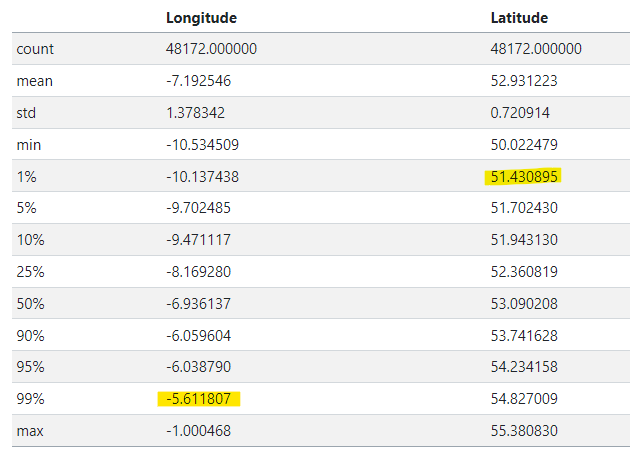

```python
# Filter out outliers if needed by taking range between 1% - 99%
df_f = df[df.apply(lambda row: (-10.13<=row['Longitude']<= -5.61) and (51.43<=row['Latitude']<=54.82), axis=1)]
```

Now, our dataset is pruned to better reflect the geolocation of bird sightings in Ireland.

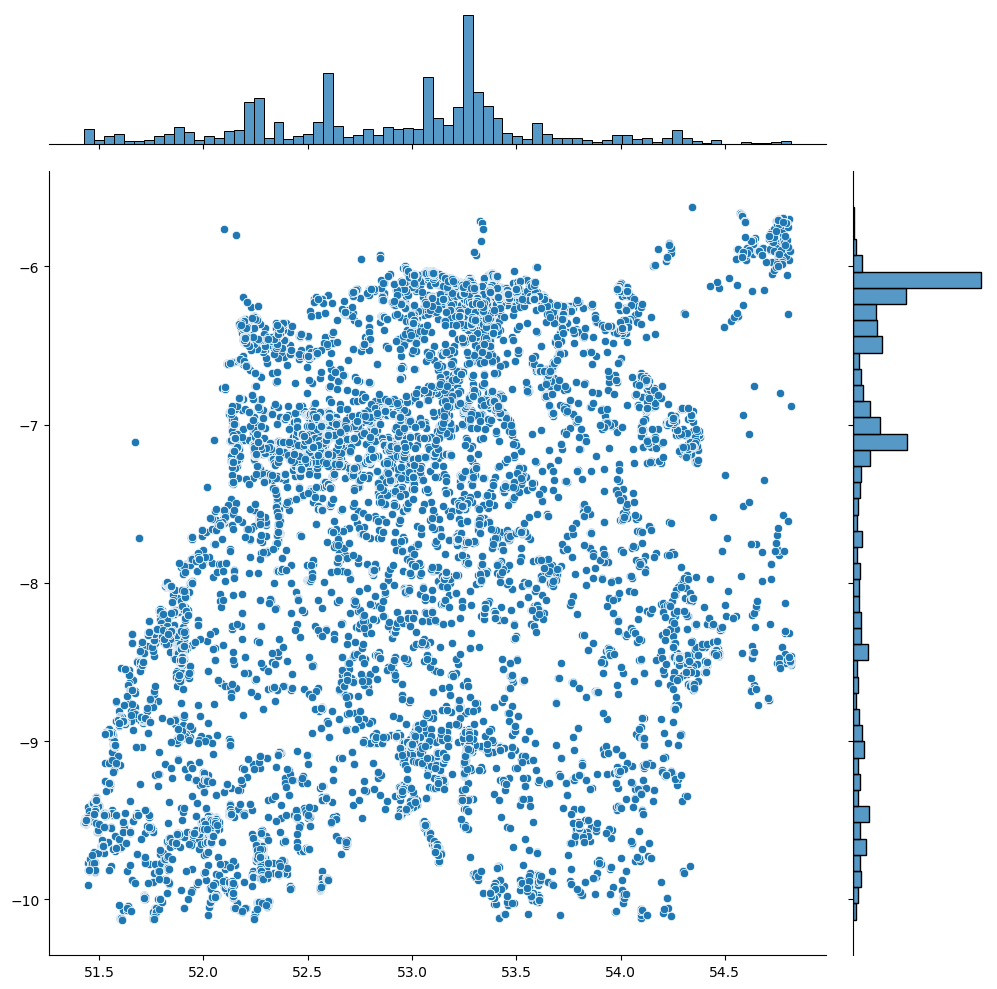


### **Single Count Per Occurrence - A Dive into Data Processing**

Next we're going to walk through the process of converting cumulative counts into single counts per occurrence, a critical preprocessing step for more meaningful visualizations and statistical analyses!

### **Ensuring Date is Correctly Formatted**

First and foremost, we need our dates to be consistently formatted so that we can perform temporal analyses later. In the Python world, this is achieved using the fantastic Pandas library:

```python
df['Date'] = pd.to_datetime(df['Date'])
```

However, you might encounter the `SettingWithCopyWarning`. This warning is Pandas' way of saying "Be cautious, you might be changing a slice from a DataFrame." It arises when dealing with views vs. copies. You can find more about this in the Pandas documentation.

### **Creating Count Column**

We're moving away from cumulative counts and focusing on single occurrences. This simplification will aid in creating heatmaps later.

```python
df['my_count'] = 1
```

Again, you might see the `SettingWithCopyWarning`. Just a gentle reminder to tread carefully.

### **TaxonName Check**

It's essential to understand the unique counts of species (TaxonNames) to get a sense of the diversity in the dataset:

```python
pd.set_option("display.max_rows", None)
print(df['TaxonName'].value_counts(ascending=True))
```
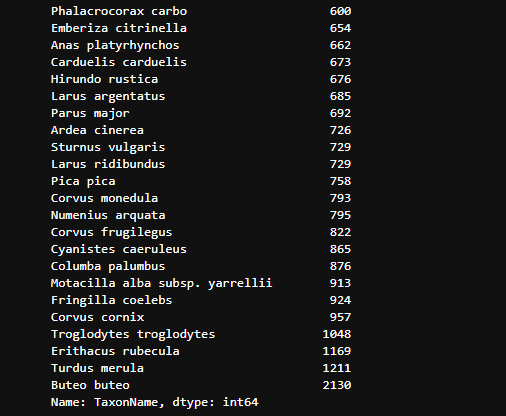
```

```

Also, displaying the total count per unique bird species:

```python
for bird in df['TaxonName'].unique():
    print('TaxonName {}; has a total count of {:.0f}'.format(bird, (df[df['TaxonName'] == bird]['Total_Count'].max())))
```
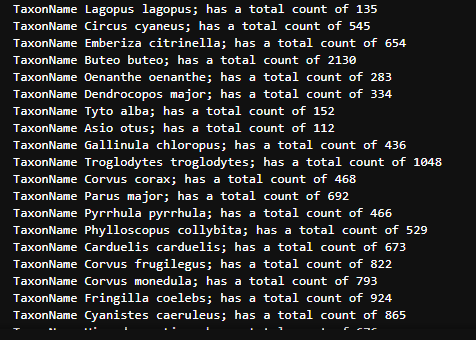

### **Grouping Species**

According to the Red List, bird species are classified into Breeding, Wintering, Passage, and Breeding&Wintering. Grouping them this way can provide valuable insights.

You can filter rows in a dataframe based on a column's values. This [link](https://sparkbyexamples.com/pandas/pandas-filter-by-column-value/) provides comprehensive ways to do this.

For instance:

```python
df_b = df[df['TaxonName'].isin(['Coturnix coturnix', 'Perdix perdix', ... ])]
```

By repeating this for all categories, we can get a count of the total number of bird species:

```python
print("The number of bird species from Red List found in the dataset is: ", amount)
```

### **Visualization - HeatMaps with Time**

Visualization is an integral component in the data analysis pipeline, offering a unique avenue to present complex datasets in a digestible format. But when we have temporal and spatial dimensions in the mix, the challenge arises: How do we efficiently display both? The answer is quite simply: Heatmaps. 

Heatmaps are a fantastic way to visualize dense data. But when combined with time, they provide an animated sequence that's both visually appealing and informative.

We will use the Folium library. With a combination of other plugins like `HeatMap` and `HeatMapWithTime`, we can create dynamic visualizations:

```python
import folium
from folium.plugins import HeatMap, HeatMapWithTime
...
m = folium.Map(location=center, zoom_start=7, tiles='Stamen Toner')
...
hm = HeatMap(data=df_b[['Latitude','Longitude','my_count']]).add_to(m)
```

In the end, this preprocessing and visualization process gives us a vivid picture of the dataset's richness. We can see not only the spatial density of bird species but also track their movements and concentrations over time.



### **Organizing Your Data**

First, we need our data in the right format. Given the dates from various dataframes `df_b`, `df_bw`, `df_w`, and `df_p`, you'd want to sort them:

```python
df_b['Date'].sort_values().unique()
```

After sorting dates from various datasets, we obtained a unique array of dates. The mentioned process is crucial because we intend to visualize data for each specific date.

```
array(['2003-03-10T00:00:00.000000000', '2004-08-29T00:00:00.000000000',
       '2004-12-02T00:00:00.000000000', '2006-07-01T00:00:00.000000000',
       '2006-09-21T00:00:00.000000000', '2008-12-07T00:00:00.000000000',
       '2009-03-08T00:00:00.000000000', '2009-08-26T00:00:00.000000000',
       '2009-09-23T00:00:00.000000000', '2010-03-08T00:00:00.000000000',
       '2010-04-08T00:00:00.000000000', '2010-07-08T00:00:00.000000000',
       '2010-08-09T00:00:00.000000000', '2010-09-13T00:00:00.000000000',
       '2010-09-16T00:00:00.000000000', '2010-09-17T00:00:00.000000000',
       '2010-09-21T00:00:00.000000000', '2010-10-17T00:00:00.000000000',
       '2010-10-23T00:00:00.000000000', '2011-01-09T00:00:00.000000000',
       '2011-03-09T00:00:00.000000000', '2011-08-19T00:00:00.000000000',
       '2011-08-20T00:00:00.000000000', '2011-08-21T00:00:00.000000000',
       '2011-08-31T00:00:00.000000000', '2011-09-13T00:00:00.000000000',
       '2011-09-17T00:00:00.000000000', '2011-10-10T00:00:00.000000000',
       '2011-12-09T00:00:00.000000000', '2016-11-19T00:00:00.000000000',
       '2017-02-12T00:00:00.000000000', '2017-10-15T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-04-18T00:00:00.000000000',
       '2018-05-03T00:00:00.000000000', '2020-08-26T00:00:00.000000000',
       '2020-10-09T00:00:00.000000000', '2020-12-09T00:00:00.000000000',
       '2021-05-16T00:00:00.000000000'], dtype='datetime64[ns]')
```

### **Creating a Time-Series HeatMap**

The power of `folium` comes into play when creating time-series heatmaps. First, we break down our data into hours for each category:

```python
df_hour_list_b = []
for sale_date in df_b['Date'].sort_values().unique():
    df_hour_list_b.append(df_b.loc[df_b['Date'] == sale_date, ['Latitude', 'Longitude', 'my_count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
```

In the code snippet above, for every unique date in our sorted dataset, we're gathering data on Latitude, Longitude, and my_count. This helps in aggregating bird counts (or whichever entity is represented by `my_count`) at each unique geographic location.

### **Visualizing the HeatMap**

Here's where the magic happens. Using the organized data, we create a heatmap:

```python
base_map_breeding = folium.Map(location=[53.305494, -7.737649], tiles='Stamen Toner',  zoom_start=6)
HeatMapWithTime(df_hour_list_b, radius=25, gradient={0.2: 'blue', 0.4: 'lime', 0.7: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map_breeding)
```

The `HeatMapWithTime` function creates a time-series heatmap with a gradient color scale. This means the areas with higher bird counts would appear 'red', and those with lower counts will lean towards 'blue'.


### **Expanding the Analysis**

The method described above can be expanded for the other categories: `df_bw`, `df_w`, and `df_p`. The end result would be a series of heatmaps for each category.

### **Monthly Grouping for Better Temporal Insights**

Often, daily data can be noisy. To see trends better, you might want to group data by month:

```python
df_months = []
for sale_date in df_b['Date'].sort_values().unique():
    df_months.append(df_b.loc[df_b['Date'] == sale_date, ['Latitude', 'Longitude', 'my_count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist())
```



In [219]:
base_map_test


#### **Conclusion:**

In the context of the provided code, these heatmaps can provide profound insights into patterns, be it the migration, population density, or any event-based clustering of birds in different geographical locations over time. By visualizing these trends, organizations and researchers can derive actionable insights, such as resource allocation for bird conservation, identifying hotspots for bird-watching, and understanding migration patterns.

Hope you had a great time reading this! 📚 For a deeper dive into heatmap techniques and visualizations, feel free to check out this article 📖 [here](https://medium.com/analytics-vidhya/choropleth-maps-plotly-folium-ba18350fb89e) and the GitHub repo 🖥️ [here](https://github.com/zelatyna/Choropleth-maps/blob/master/Properties%20Prices%20Ireland.ipynb).

Also for the full code and datasets please see my own GitHub repo 🖥️ [here](https://github.com/c123ian/Bird_Visualisation).